In [47]:
import pandas as pd
import numpy as np
import pickle

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from pygam import LogisticGAM

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500) #View max number columns

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
%matplotlib inline

In [48]:
dataloc = '/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - Unsupervised GANS/Medicare/data/'
plotloc = '/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - Unsupervised GANS/Medicare/plots/'
modelsloc = '/Users/marionaidoo/Library/Mobile Documents/com~apple~CloudDocs/GitHub/MscResearch/MscAnomaly - GANS/Deep Learning - Unsupervised GANS/Medicare/cache/'
dfprefix = 'Medicare'

In [49]:
#Select 20% of data from Main dataset
datafrac = 0.2

In [50]:
#Save Engineered Dataset
#pickle.dump(gans_pca_df, open('data/' + dfprefix + '_' + str(datafrac) + '_Unsupervised_GANSLabelData.engineered.pkl','wb'))

#Load GANS Data with Labels
gans_pca_df = pickle.load(open('data/' + dfprefix + '_' + str(datafrac) + '_Unsupervised_GANSLabelData.engineered.pkl','rb'))
#auto_pca_df = pickle.load(open('data/Medicare_0.2_Unsupervised_AEData_LelledData.engineered.pkl','rb'))

In [51]:
#Using Auto Encoder / GANS as Ground Truth Labels
data = gans_pca_df #auto_pca_df
data.rename(columns={'AnomalyInd': 'Class'}, inplace=True)

In [52]:
data.head()

,PracTypeClean_Internal Medicine,PracTypeClean_Pathology,PracTypeClean_Anesthesiology,PracTypeClean_Family Practice,PracTypeClean_Obstetrics & Gynecology,PracTypeClean_General Surgery,PracTypeClean_Urology,PracTypeClean_Cardiac Surgery,PracTypeClean_Physician Assistant,PracTypeClean_Physical Therapist in Private Practice,PracTypeClean_Dermatology,PracTypeClean_Certified Registered Nurse Anesthetist (CRNA),PracTypeClean_Mass Immunizer Roster Biller,PracTypeClean_Physical Medicine and Rehabilitation,PracTypeClean_Radiation Oncology,PracTypeClean_Infectious Disease,PracTypeClean_Orthopedic Surgery,PracTypeClean_Licensed Clinical Social Worker,PracTypeClean_Certified Clinical Nurse Specialist,PracTypeClean_Endocrinology,PracTypeClean_Chiropractic,PracTypeClean_Diagnostic Radiology,PracTypeClean_Centralized Flu,PracTypeClean_Rheumatology,PracTypeClean_General Practice,PracTypeClean_Neurology,PracTypeClean_Emergency Medicine,PracTypeClean_Nephrology,PracTypeClean_Other,PracTypeClean_Ophthalmology,PracTypeClean_Nurse Practitioner,PracTypeClean_Pulmonary Disease,PracTypeClean_Otolaryngology,PracTypeClean_Plastic and Reconstructive Surgery,"PracTypeClean_Psychologist, Clinical",PracTypeClean_Cardiovascular Disease (Cardiology),PracTypeClean_Ambulance Service Provider,PracTypeClean_Psychiatry,PracTypeClean_Interventional Cardiology,PracTypeClean_Audiologist,PracTypeClean_Geriatric Medicine,PracTypeClean_Neurosurgery,PracTypeClean_Gastroenterology,PracTypeClean_Thoracic Surgery,PracTypeClean_Critical Care (Intensivists),PracTypeClean_Pain Management,PracTypeClean_Podiatry,PracTypeClean_Optometry,PracTypeClean_Hematology-Oncology,PracTypeClean_Ambulatory Surgical Center,PracTypeClean_Medical Oncology,PracTypeClean_Allergy/ Immunology,PracTypeClean_Pediatric Medicine,PracTypeClean_Occupational Therapist in Private Practice,PracTypeClean_Independent Diagnostic Testing Facility (IDTF),PracTypeClean_Clinical Laboratory,PracTypeClean_Registered Dietitian or Nutrition Professional,PracTypeClean_Vascular Surgery,PracTypeClean_Interventional Radiology,PracTypeClean_Clinical Cardiatric Electrophysiology,PracTypeClean_Anesthesiology Assistant,PracTypeClean_Oral Surgery (Dentists only),PracTypeClean_Colorectal Surgery (Proctology),PracTypeClean_Interventional Pain Management,NUMBER_OF_HCPCS,TOTAL_SERVICES,TOTAL_UNIQUE_BENES,TOTAL_SUBMITTED_CHRG_AMT,NUMBER_OF_DRUG_HCPCS,TOTAL_DRUG_SERVICES,TOTAL_DRUG_UNIQUE_BENES,TOTAL_DRUG_SUBMITTED_CHRG_AMT,BENEFICIARY_AVERAGE_AGE,BENEFICIARY_RACE_BLACK_COUNT,BENEFICIARY_RACE_API_COUNT,BENEFICIARY_RACE_HISPANIC_COUNT,BENEFICIARY_RACE_NATIND_COUNT,BENEFICIARY_CC_AFIB_PERCENT,BENEFICIARY_CC_ALZRDSD_PERCENT,BENEFICIARY_CC_ASTHMA_PERCENT,BENEFICIARY_CC_CANCER_PERCENT,BENEFICIARY_CC_CHF_PERCENT,BENEFICIARY_CC_DEPR_PERCENT,BENEFICIARY_CC_DIAB_PERCENT,BENEFICIARY_CC_HYPERL_PERCENT,BENEFICIARY_CC_HYPERT_PERCENT,BENEFICIARY_CC_OST_PERCENT,BENEFICIARY_CC_RAOA_PERCENT,BENEFICIARY_CC_SCHIOT_PERCENT,BENEFICIARY_CC_STRK_PERCENT,BENEFICIARY_AVERAGE_RISK_SCORE,Class,AnomalyScore
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,0.216550,1855,0.538425,0.043702,-0.071283,0.105109,-0.001732,77,-0.210320,0.247381,-0.178791,-0.044808,0.590762,-0.281051,-0.703368,0.254320,-0.484701,-0.742595,-0.375281,0.497357,0.168606,0.29079,-0.133092,-0.300137,0.045295,-0.646648,0.0,45.238075
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,-0.054328,513,0.007269,-0.348516,-0.081462,-0.051046,-0.081593,70,-0.099810,-0.123219,-0.178791,-0.044808,-0.102384,0.800379,-0.141250,-0.312725,-0.145218,0.215892,0.030987,0.080697,-0.280641,0.13393,0.084434,-0.097587,1.275540,-0.281521,0.0,28.280134
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,-0.102643,198,-0.084547,-0.348516,-0.081462,-0.051046,-0.081593,69,-0

In [53]:
np.random.seed(0)

test_cols = data.columns

n_real = np.sum(data.Class==0) 
n_test = np.sum(data.Class==1) 
train_fraction = 0.6
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

trainx = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

testx = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(trainx), len(testx) )

X_col = testx.columns[:-1]
y_col = testx.columns[-1]

#Extract the Y variable
trainy = pd.DataFrame(trainx.iloc[:,-2]).astype('int64')
testy = pd.DataFrame(testx.iloc[:,-2]).astype('int64')

trainx = trainx.iloc[:,:-2]
testx = testx.iloc[:,:-2]


classes 0, 1:  37943 4216
train, test:  25294 16865


In [54]:
trainx.shape, trainy.shape

((25294, 91), (25294, 1))

In [55]:
trainx_cols = trainx.columns
trainy_cols = trainy.columns

In [56]:
trainx_sm = trainx
trainy_sm = trainy

In [57]:
###Under Sample Data for the Class Imbalance in Classification model
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
trainx, trainy, id_rus = rus.fit_sample(trainx_sm, trainy_sm)

In [58]:
# ###OVER Sample Data for the Class Imbalance in Classification model
####Result in lower results
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler()
# trainx, trainy = ros.fit_sample(trainx_sm, trainy_sm)

In [59]:
# ##############SMOTE - Over sampling for the imbalance of Target variable-------
# ##############Apply only to the TRAIN SET
# sm = SMOTE(random_state=12, ratio = 0.1)
# trainx, trainy = sm.fit_sample(trainx_sm.values, trainy_sm.values)

In [60]:
#Convert the Array to Dataframe and Adding the colun Names
trainx = pd.DataFrame(trainx,columns=trainx_cols)
trainy = pd.DataFrame(trainy,columns=trainy_cols)

In [61]:
pd.DataFrame(trainx)

,PracTypeClean_Internal Medicine,PracTypeClean_Pathology,PracTypeClean_Anesthesiology,PracTypeClean_Family Practice,PracTypeClean_Obstetrics & Gynecology,PracTypeClean_General Surgery,PracTypeClean_Urology,PracTypeClean_Cardiac Surgery,PracTypeClean_Physician Assistant,PracTypeClean_Physical Therapist in Private Practice,PracTypeClean_Dermatology,PracTypeClean_Certified Registered Nurse Anesthetist (CRNA),PracTypeClean_Mass Immunizer Roster Biller,PracTypeClean_Physical Medicine and Rehabilitation,PracTypeClean_Radiation Oncology,PracTypeClean_Infectious Disease,PracTypeClean_Orthopedic Surgery,PracTypeClean_Licensed Clinical Social Worker,PracTypeClean_Certified Clinical Nurse Specialist,PracTypeClean_Endocrinology,PracTypeClean_Chiropractic,PracTypeClean_Diagnostic Radiology,PracTypeClean_Centralized Flu,PracTypeClean_Rheumatology,PracTypeClean_General Practice,PracTypeClean_Neurology,PracTypeClean_Emergency Medicine,PracTypeClean_Nephrology,PracTypeClean_Other,PracTypeClean_Ophthalmology,PracTypeClean_Nurse Practitioner,PracTypeClean_Pulmonary Disease,PracTypeClean_Otolaryngology,PracTypeClean_Plastic and Reconstructive Surgery,"PracTypeClean_Psychologist, Clinical",PracTypeClean_Cardiovascular Disease (Cardiology),PracTypeClean_Ambulance Service Provider,PracTypeClean_Psychiatry,PracTypeClean_Interventional Cardiology,PracTypeClean_Audiologist,PracTypeClean_Geriatric Medicine,PracTypeClean_Neurosurgery,PracTypeClean_Gastroenterology,PracTypeClean_Thoracic Surgery,PracTypeClean_Critical Care (Intensivists),PracTypeClean_Pain Management,PracTypeClean_Podiatry,PracTypeClean_Optometry,PracTypeClean_Hematology-Oncology,PracTypeClean_Ambulatory Surgical Center,PracTypeClean_Medical Oncology,PracTypeClean_Allergy/ Immunology,PracTypeClean_Pediatric Medicine,PracTypeClean_Occupational Therapist in Private Practice,PracTypeClean_Independent Diagnostic Testing Facility (IDTF),PracTypeClean_Clinical Laboratory,PracTypeClean_Registered Dietitian or Nutrition Professional,PracTypeClean_Vascular Surgery,PracTypeClean_Interventional Radiology,PracTypeClean_Clinical Cardiatric Electrophysiology,PracTypeClean_Anesthesiology Assistant,PracTypeClean_Oral Surgery (Dentists only),PracTypeClean_Colorectal Surgery (Proctology),PracTypeClean_Interventional Pain Management,NUMBER_OF_HCPCS,TOTAL_SERVICES,TOTAL_UNIQUE_BENES,TOTAL_SUBMITTED_CHRG_AMT,NUMBER_OF_DRUG_HCPCS,TOTAL_DRUG_SERVICES,TOTAL_DRUG_UNIQUE_BENES,TOTAL_DRUG_SUBMITTED_CHRG_AMT,BENEFICIARY_AVERAGE_AGE,BENEFICIARY_RACE_BLACK_COUNT,BENEFICIARY_RACE_API_COUNT,BENEFICIARY_RACE_HISPANIC_COUNT,BENEFICIARY_RACE_NATIND_COUNT,BENEFICIARY_CC_AFIB_PERCENT,BENEFICIARY_CC_ALZRDSD_PERCENT,BENEFICIARY_CC_ASTHMA_PERCENT,BENEFICIARY_CC_CANCER_PERCENT,BENEFICIARY_CC_CHF_PERCENT,BENEFICIARY_CC_DEPR_PERCENT,BENEFICIARY_CC_DIAB_PERCENT,BENEFICIARY_CC_HYPERL_PERCENT,BENEFICIARY_CC_HYPERT_PERCENT,BENEFICIARY_CC_OST_PERCENT,BENEFICIARY_CC_RAOA_PERCENT,BENEFICIARY_CC_SCHIOT_PERCENT,BENEFICIARY_CC_STRK_PERCENT,BENEFICIARY_AVERAGE_RISK_SCORE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,-0.094146,49.0,-0.240446,0.435921,-0.078391,-0.006430,-0.073713,67.0,-0.210320,0.272088,-0.178791,-0.044808,-0.993573,-0.821766,-1.335751,-0.879770,-1.107086,0.159511,0.669408,-0.700542,-0.505265,-0.964091,-0.840053,-0.401411,-0.638173,-0.924481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-0.115732,14.0,-0.243377,-0.348516,-0.081462,-0.051046,-0.081593,73.0,-0.210320,-0.123219,-0.178791,-0.044808,-0.993573,-0.821766,-1.335751,-0.879770,-1.107086,-1.475557,-1.826237,1.174430,0.617854,-0.964091,-2.308355,

In [62]:
np.sum(trainy.Class==0)/len(trainy) ,np.sum(trainy.Class==1) /len(trainy)

(0.5, 0.5)

In [63]:
np.sum(testy.Class==0)/len(testy) ,np.sum(testy.Class==1) /len(testy)

(0.8999703528016603, 0.10002964719833976)

In [64]:
# trainx = trainx.iloc[:,:-2]
# testx = testx.iloc[:,:-2]

In [65]:
trainy.dtypes

Class    int64
dtype: object

In [66]:
trainx.head(100)

,PracTypeClean_Internal Medicine,PracTypeClean_Pathology,PracTypeClean_Anesthesiology,PracTypeClean_Family Practice,PracTypeClean_Obstetrics & Gynecology,PracTypeClean_General Surgery,PracTypeClean_Urology,PracTypeClean_Cardiac Surgery,PracTypeClean_Physician Assistant,PracTypeClean_Physical Therapist in Private Practice,PracTypeClean_Dermatology,PracTypeClean_Certified Registered Nurse Anesthetist (CRNA),PracTypeClean_Mass Immunizer Roster Biller,PracTypeClean_Physical Medicine and Rehabilitation,PracTypeClean_Radiation Oncology,PracTypeClean_Infectious Disease,PracTypeClean_Orthopedic Surgery,PracTypeClean_Licensed Clinical Social Worker,PracTypeClean_Certified Clinical Nurse Specialist,PracTypeClean_Endocrinology,PracTypeClean_Chiropractic,PracTypeClean_Diagnostic Radiology,PracTypeClean_Centralized Flu,PracTypeClean_Rheumatology,PracTypeClean_General Practice,PracTypeClean_Neurology,PracTypeClean_Emergency Medicine,PracTypeClean_Nephrology,PracTypeClean_Other,PracTypeClean_Ophthalmology,PracTypeClean_Nurse Practitioner,PracTypeClean_Pulmonary Disease,PracTypeClean_Otolaryngology,PracTypeClean_Plastic and Reconstructive Surgery,"PracTypeClean_Psychologist, Clinical",PracTypeClean_Cardiovascular Disease (Cardiology),PracTypeClean_Ambulance Service Provider,PracTypeClean_Psychiatry,PracTypeClean_Interventional Cardiology,PracTypeClean_Audiologist,PracTypeClean_Geriatric Medicine,PracTypeClean_Neurosurgery,PracTypeClean_Gastroenterology,PracTypeClean_Thoracic Surgery,PracTypeClean_Critical Care (Intensivists),PracTypeClean_Pain Management,PracTypeClean_Podiatry,PracTypeClean_Optometry,PracTypeClean_Hematology-Oncology,PracTypeClean_Ambulatory Surgical Center,PracTypeClean_Medical Oncology,PracTypeClean_Allergy/ Immunology,PracTypeClean_Pediatric Medicine,PracTypeClean_Occupational Therapist in Private Practice,PracTypeClean_Independent Diagnostic Testing Facility (IDTF),PracTypeClean_Clinical Laboratory,PracTypeClean_Registered Dietitian or Nutrition Professional,PracTypeClean_Vascular Surgery,PracTypeClean_Interventional Radiology,PracTypeClean_Clinical Cardiatric Electrophysiology,PracTypeClean_Anesthesiology Assistant,PracTypeClean_Oral Surgery (Dentists only),PracTypeClean_Colorectal Surgery (Proctology),PracTypeClean_Interventional Pain Management,NUMBER_OF_HCPCS,TOTAL_SERVICES,TOTAL_UNIQUE_BENES,TOTAL_SUBMITTED_CHRG_AMT,NUMBER_OF_DRUG_HCPCS,TOTAL_DRUG_SERVICES,TOTAL_DRUG_UNIQUE_BENES,TOTAL_DRUG_SUBMITTED_CHRG_AMT,BENEFICIARY_AVERAGE_AGE,BENEFICIARY_RACE_BLACK_COUNT,BENEFICIARY_RACE_API_COUNT,BENEFICIARY_RACE_HISPANIC_COUNT,BENEFICIARY_RACE_NATIND_COUNT,BENEFICIARY_CC_AFIB_PERCENT,BENEFICIARY_CC_ALZRDSD_PERCENT,BENEFICIARY_CC_ASTHMA_PERCENT,BENEFICIARY_CC_CANCER_PERCENT,BENEFICIARY_CC_CHF_PERCENT,BENEFICIARY_CC_DEPR_PERCENT,BENEFICIARY_CC_DIAB_PERCENT,BENEFICIARY_CC_HYPERL_PERCENT,BENEFICIARY_CC_HYPERT_PERCENT,BENEFICIARY_CC_OST_PERCENT,BENEFICIARY_CC_RAOA_PERCENT,BENEFICIARY_CC_SCHIOT_PERCENT,BENEFICIARY_CC_STRK_PERCENT,BENEFICIARY_AVERAGE_RISK_SCORE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,-0.094146,49.0,-0.240446,0.435921,-0.078391,-0.006430,-0.073713,67.0,-0.210320,0.272088,-0.178791,-0.044808,-0.993573,-0.821766,-1.335751,-0.879770,-1.107086,0.159511,0.669408,-0.700542,-0.505265,-0.964091,-0.840053,-0.401411,-0.638173,-0.924481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-0.115732,14.0,-0.243377,-0.348516,-0.081462,-0.051046,-0.081593,73.0,-0.210320,-0.123219,-0.178791,-0.044808,-0.993573,-0.821766,-1.335751,-0.879770,-1.107086,-1.475557,-1.826237,1.174430,0.617854,-0.964091,-2.308355,

In [67]:
trainy.head(10),testy.head(10)

(   Class
 0      0
 1      0
 2      0
 3      0
 4      0
 5      0
 6      0
 7      0
 8      0
 9      0,    Class
 0      0
 1      0
 2      0
 3      0
 4      0
 5      0
 6      0
 7      0
 8      0
 9      0)

In [68]:
##Defining the models 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression()
LGR_Classifier.fit(trainx, trainy)

# Train Decision Tree Model
RDF_Classifier = RandomForestClassifier(random_state=0)
RDF_Classifier.fit(trainx, trainy)

#LDA_Classifier = LinearDiscriminantAnalysis()
#LDA_Classifier.fit(trainx,trainy)

#KNN_Classifier = KNeighborsClassifier()
#KNN_Classifier.fit(trainx,trainy)

#GAM_Classifier = LogisticGAM()
#GAM_Classifier.fit(trainx,trainy)

DT_Classifier = DecisionTreeClassifier()
DT_Classifier.fit(trainx,trainy)

#SVC_Classifier = SVC()
#SVC_Classifier.fit(trainx,trainy)

#XGB_Classifier = XGBClassifier()

XGB_Classifier = XGBClassifier(learning_rate =0.1,
             n_estimators=1000,
             max_depth=5,
             min_child_weight=3,
             gamma=0,
             subsample=0.7,
             colsample_bytree=0.8,
             reg_alpha=0.1,
             objective= 'binary:logistic',
             nthread=4,
             scale_pos_weight=1,
             seed=27)
XGB_Classifier.fit(trainx,trainy)

models = []

models.append((1,'LR', LGR_Classifier))
#models.append((2,'LDA', LDA_Classifier))
#models.append((2,'GAM', GAM_Classifier))
models.append((2,'CART', DT_Classifier))
#models.append((5,'SVM', SVC_Classifier))
models.append((3,'XGB', XGB_Classifier))
models.append((4,'RF', RDF_Classifier))


In [69]:
# from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
# import sklearn as sklearn

# scoring = {'accuracy' : make_scorer(accuracy_score), 
#            'precision' : make_scorer(precision_score),
#            'recall' : make_scorer(recall_score), 
#            'f1_score' : make_scorer(f1_score)}

# kfold = KFold(n_splits=10, random_state=42)

# results = sklearn.model_selection.cross_validate(estimator=LGR_Classifier,
#                                           X=testx,
#                                           y=testy,
#                                           cv=kfold,
#                                           scoring=scoring)

# accuracy = np.mean(results['test_accuracy'])
# precision = np.mean(results['test_precision'])
# recall = np.mean(results['test_recall'])
# f1 = np.mean(results['test_f1_score'])

In [70]:
 ##Run the Models against Test Dataset and Performance Metrics on the Test Predictions Models
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import sklearn as sklearn

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

results = []
names = []
# Define a result table as a DataFramess
testresult_df = pd.DataFrame(columns=['classifiers', 'accuracy','precision','recall','f1','fpr','tpr','auc','sensitivity','specificity'])

##Train/Predict Models
for id_num,name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    
#     if name == 'XGB':
# #        testmodel = model.predict(xgboost.DMatrix(testx), ntree_limit = model.best_iteration+1)
#         testmodel = model.predict(testx)
#     else:
#         testmodel = model.predict(testx)

    testmodel = model.predict(testx)  
#     cv_results = cross_val_score(model, testx, testy, cv=kfold, scoring='accuracy')
    cv_results = sklearn.model_selection.cross_validate(model,
                                          X=testx,
                                          y=testy,
                                          cv=kfold,
                                          scoring=scoring)
    
    cv_accuracy = np.mean(cv_results['test_accuracy'])
    cv_precision = np.mean(cv_results['test_precision'])
    cv_recall = np.mean(cv_results['test_recall'])
    cv_f1 = np.mean(cv_results['test_f1_score'])
    
    print('cv_accuracy : ', cv_accuracy)
    print('cv_precision : ', cv_precision)
    print('cv_recall : ', cv_recall)
    print('cv_f1 : ', cv_f1)
    print()

    accuracy = metrics.accuracy_score(testy, testmodel)
    precision = metrics.precision_score(testy, testmodel)
    recall = metrics.recall_score(testy, testmodel)
    f1 = metrics.f1_score(testy, testmodel)
    
    confusion_matrix = metrics.confusion_matrix(testy, testmodel)
    classification = metrics.classification_report(testy, testmodel)
    fpr, tpr, thresholds = metrics.roc_curve(testy, testmodel)
    roc_auc = metrics.auc(fpr, tpr)
    
    #Sensitivity and Specificity
    #print('Confusion Matrix : \n', confusion_matrix)

    total1=sum(sum(confusion_matrix))
    #####from confusion matrix calculate accuracy
    accuracy1=(confusion_matrix[0,0]+confusion_matrix[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
    print('Specificity : ', specificity1)
    
    #######
    ###Cross Validation Results
    results.append((cv_results,cv_accuracy))
    names.append((id_num,name))
    msg = '%f: %s: %f' % (id_num,name, cv_accuracy) #cv_results.mean(), cv_results.std())
    print('Cross Validation Results: ' + msg)

    #Saving the Trained Model
    filename = name + '.pkl'
    pickle.dump(testmodel, open(modelsloc + filename, 'wb'))
    print(name + ': Model Saved')
    

    
    testresult_df = testresult_df.append({'classifiers': name,
                                          'precision': "{:.3f}".format(float(precision)), #precision,
                                          'accuracy': "{:.3f}".format(float(accuracy)), 
                                          'recall':"{:.3f}".format(float(recall)),
                                          'f1':"{:.3f}".format(float(f1)),
                                          'fpr':fpr, 
                                          'tpr':tpr, 
                                          'auc':"{:.3f}".format(float(roc_auc)),
                                          'sensitivity':"{:.3f}".format(float(sensitivity1)), 
                                          'specificity':"{:.3f}".format(float(specificity1))
                                         }, ignore_index=True)
    
    print ('Saved Model to Result Table')
    
    print()
    print("Confusion Matrix:" "\n", confusion_matrix)
    print()
    
    #Sensitivity and Specificity
    print()
    print("Confusion Matrix:" "\n", classification)
    print()
    
    


cv_accuracy :  0.8889127379071416
cv_precision :  0.10416666666666667
cv_recall :  0.10053380782918149
cv_f1 :  0.009061946902654865

Accuracy :  0.8016602431070264
Sensitivity :  0.8128211885623929
Specificity :  0.7012448132780082
Cross Validation Results: 1.000000: LR: 0.888913
LR: Model Saved
Saved Model to Result Table

Confusion Matrix:
 [[12337  2841]
 [  504  1183]]


Confusion Matrix:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     15178
           1       0.29      0.70      0.41      1687

    accuracy                           0.80     16865
   macro avg       0.63      0.76      0.65     16865
weighted avg       0.89      0.80      0.83     16865


cv_accuracy :  0.8279004332200535
cv_precision :  0.10070921985815602
cv_recall :  0.10053380782918149
cv_f1 :  0.0024703976068802197

Accuracy :  0.7002075303883784
Sensitivity :  0.7015417050994861
Specificity :  0.6882039122703023
Cross Validation Results: 2.000000: CART

============================= ROC Curve ===============================



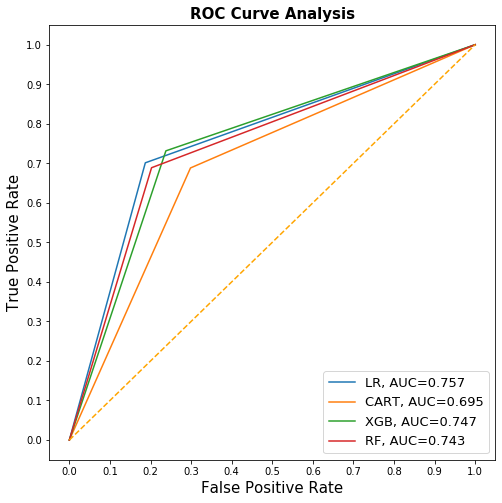

In [71]:
## Ploting the ROC-AUC Curve

# Set name of the classifiers as index labels
testresult_df.set_index('classifiers', inplace=True)
print('============================= ROC Curve ===============================' "\n")
fig = plt.figure(figsize=(8,8))

for i in testresult_df.index:
    plt.plot(testresult_df.loc[i]['fpr'], 
             testresult_df.loc[i]['tpr'], 
             #label="{}, AUC={:.3f}".format(i, testresult_df.loc[i]['auc'])
             label="{}, AUC={}".format(i, testresult_df.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.savefig(plotloc + 'ROCPlot_SupervisedModels.png')
plt.show()

In [72]:
sel_cols = ['accuracy', 'sensitivity','specificity',  'auc']
testresult_df[sel_cols]

,accuracy,sensitivity,specificity,auc
classifiers,,,,
LR,0.802,0.813,0.701,0.757
CART,0.700,0.702,0.688,0.695
XGB,0.759,0.762,0.731,0.747
RF,0.787,0.797,0.689,0.743


In [73]:
sel_cols = ['accuracy', 'precision', 'recall' ,'sensitivity','specificity','f1',  'auc']
testresult_df[sel_cols]

,accuracy,precision,recall,sensitivity,specificity,f1,auc
classifiers,,,,,,,
LR,0.802,0.294,0.701,0.813,0.701,0.414,0.757
CART,0.700,0.204,0.688,0.702,0.688,0.315,0.695
XGB,0.759,0.255,0.731,0.762,0.731,0.378,0.747
RF,0.787,0.274,0.689,0.797,0.689,0.392,0.743


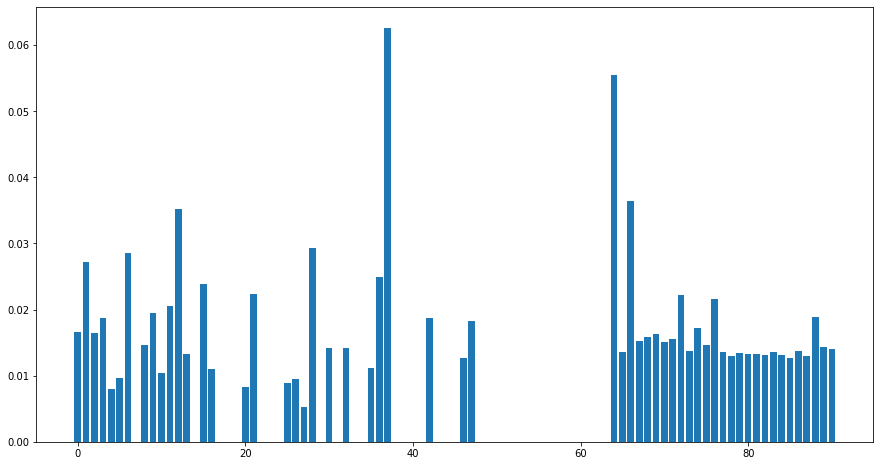

In [74]:
# plot
fig = plt.figure(figsize=(15, 8))
plt.bar(range(len(XGB_Classifier.feature_importances_)), XGB_Classifier.feature_importances_)
plt.show()

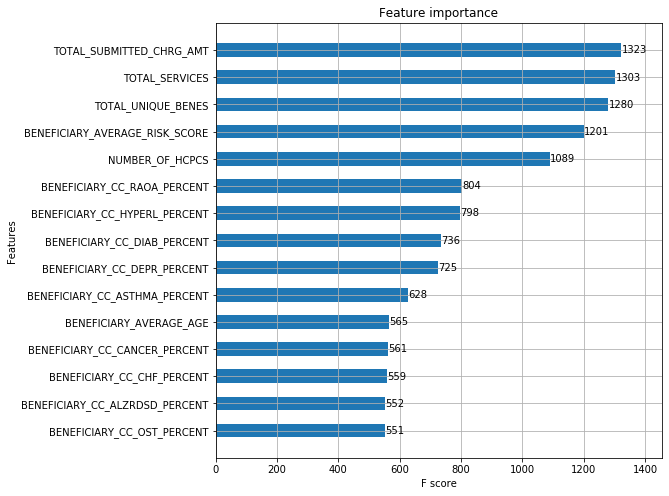

In [75]:
# plot feature importance
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_importance(XGB_Classifier,max_num_features=15, height=0.5, ax=ax)
plt.show()

## Model Interpretability - SHAP - Tree Based

In [76]:
import shap
import xgboost
import sklearn

In [77]:
# load JS visualization code to notebook
shap.initjs()

In [78]:

XGBModel = pickle.load(open(modelsloc + 'XGB.pkl', 'rb'))
RFModel = pickle.load(open(modelsloc + 'RF.pkl', 'rb'))
DTModel = pickle.load(open(modelsloc + 'CART.pkl', 'rb'))
LRModel = pickle.load(open(modelsloc + 'LR.pkl', 'rb'))
#GAMModel = pickle.load(open(modelsloc + 'GAM.pkl', 'rb'))


In [79]:
explainerXGB = shap.TreeExplainer(XGB_Classifier)

In [80]:

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(XGB_Classifier)
shap_values = explainer.shap_values(trainx[trainy.Class==1])

In [81]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript) --LOCAL
#shap.force_plot(explainer.expected_value, shap_values[:1000,:], trainx.iloc[:1000,:])
shap.force_plot(explainer.expected_value, shap_values[100,:], trainx.iloc[100,:])

In [82]:
# visualize the training set predictions - TAKES ALONG TIME
#shap.force_plot(explainer.expected_value, shap_values, trainx)

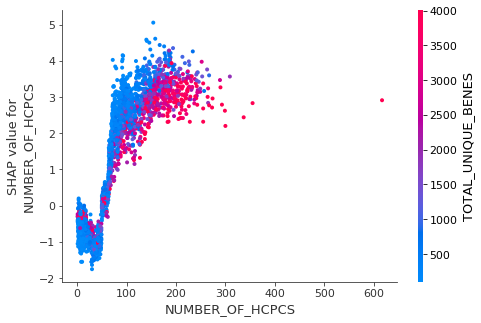

In [83]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('NUMBER_OF_HCPCS', shap_values, trainx[trainy.Class==1])

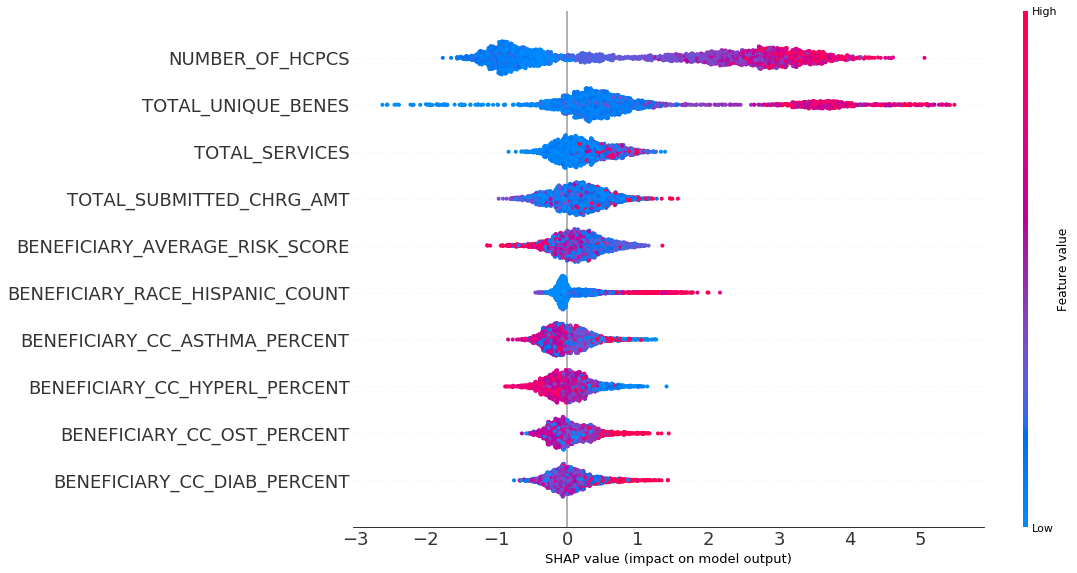

In [84]:
# summarize the effects of all the features --LOCAL
shap.summary_plot(shap_values,trainx[trainy.Class==1], max_display = 10,show=False,plot_size = (15, 8))
plt.tight_layout()
plt.tick_params(labelsize=18, length=0)
plt.savefig(plotloc + 'SHAP_FeatureSummary_Medicare_Anomaly.png', bbox_inches = "tight")
plt.show()

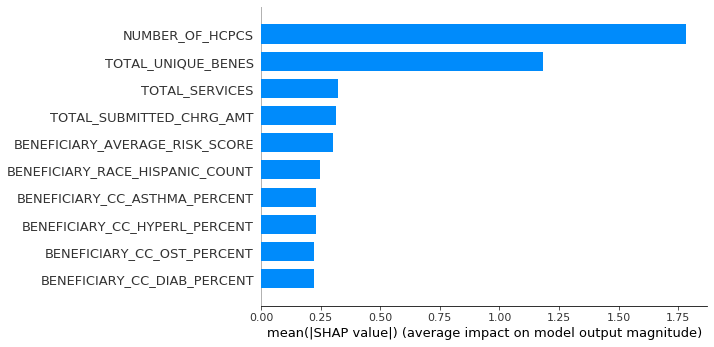

In [85]:
#GLOBAL
figsize=(20,8)
shap.summary_plot(shap_values, trainx, plot_type="bar", show = False, max_display=10)
import matplotlib.pyplot as plt
plt.savefig(plotloc + 'SHAP_FeatureImportance_Medicare_Anomaly.png', bbox_inches = "tight")

## DEcision Tree

In [51]:

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(DT_Classifier)
shap_values = explainer.shap_values(trainx)

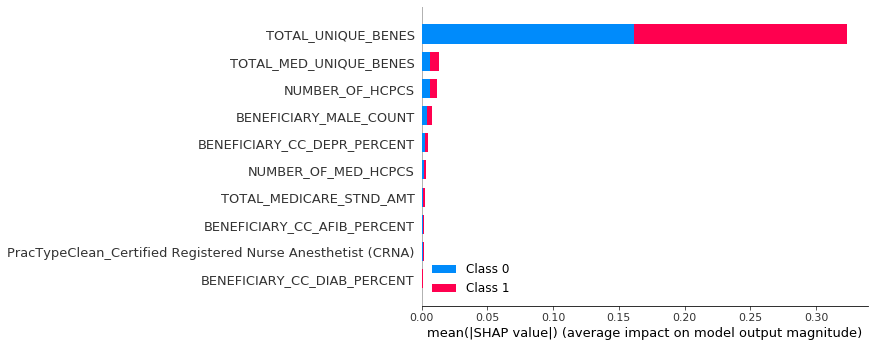

In [52]:
# summarize the effects of all the features
shap.summary_plot(shap_values,trainx, max_display=10)

## Random Forest

In [56]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(RDF_Classifier)
shap_values = explainer.shap_values(trainx)

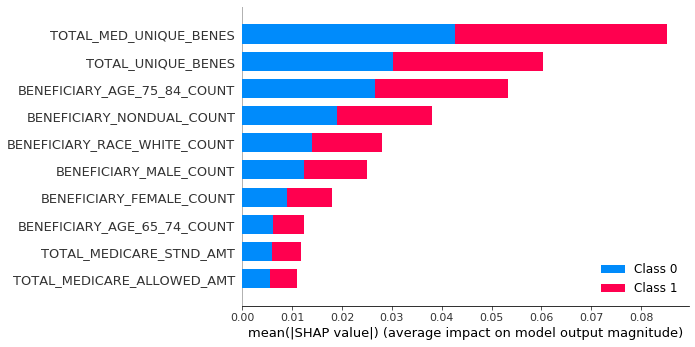

In [57]:
# summarize the effects of all the features
shap.summary_plot(shap_values,trainx, max_display=10)

## Linear Explainer

In [86]:
explainer = shap.LinearExplainer(LGR_Classifier, trainx[trainy.Class==1], feature_dependence="independent")
shap_values = explainer.shap_values(trainx[trainy.Class==1])
X_test_array = trainx[trainy.Class==1].values # we need to pass a dense version for the plotting functions

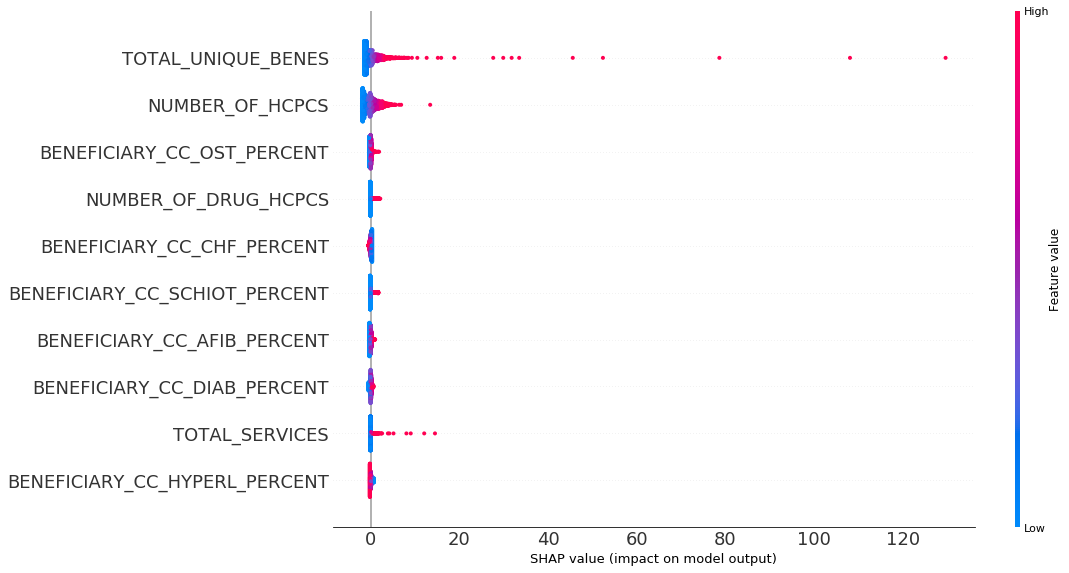

In [88]:
shap.summary_plot(shap_values, X_test_array, feature_names=trainx.columns, max_display=10,show=False,plot_size = (15, 8))
plt.tight_layout()
plt.tick_params(labelsize=18, length=0)
plt.savefig(plotloc + 'SHAP_Linear_FeatureSummary_Medicare_Anomaly.png', bbox_inches = "tight")
plt.show()

## Tuning XGBOOST

In [33]:
import xgboost as xgb

In [41]:
def modelfit(alg, dtrain, dlabel, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=pd.DataFrame(dlabel).values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], trainy['Class'].values,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\n Model Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(trainy['Class'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(trainy['Class'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [42]:
predictors = trainx.columns

modelfit(XGB_Classifier, trainx, trainy, predictors)


 Model Report
Accuracy : 0.9998
AUC Score (Train): 0.999998


TypeError: 'str' object is not callable

In [44]:
from sklearn.model_selection import GridSearchCV

##Tuning Max_DEpth ad Min_Child

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(trainx,trainy)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_



({'mean_fit_time': array([26.15622134, 25.39089699, 24.13051076, 29.60309219, 27.65751257,
         26.54973469, 31.23235135, 28.59233198, 28.06738372, 32.08381891,
         28.85100064, 25.92193918]),
  'std_fit_time': array([0.24396269, 0.7671874 , 0.50777068, 0.15468802, 0.14317616,
         0.23089164, 0.21006122, 0.63322291, 0.6443497 , 0.3386437 ,
         0.38138834, 0.81183673]),
  'mean_score_time': array([0.08008909, 0.05569243, 0.05640426, 0.07026167, 0.06550665,
         0.06624436, 0.05915942, 0.06003008, 0.05866818, 0.06763091,
         0.06271873, 0.0466392 ]),
  'std_score_time': array([0.01303519, 0.00235654, 0.00441605, 0.00845447, 0.00427257,
         0.005348  , 0.00725574, 0.01162266, 0.00266466, 0.00900557,
         0.00548483, 0.01332912]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [45]:
## tuning Gamma  ---0.3
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(trainx,trainy)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_



({'mean_fit_time': array([29.74432998, 27.25219769, 27.18374691, 27.28340516, 24.66613274]),
  'std_fit_time': array([1.2545116 , 0.25891387, 0.34546714, 0.37336653, 5.12023628]),
  'mean_score_time': array([0.05835071, 0.06009359, 0.05149832, 0.05587683, 0.0456883 ]),
  'std_score_time': array([0.00572693, 0.00752178, 0.00196444, 0.00246252, 0.00751531]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.99993629, 0.99993629, 0.99993279, 0.99993597, 0.99992897]),
  'split1_test_score': array([0.99993331, 0.99993268, 0.99992948, 0.99993459, 0.99993363]),
  'split2_test_score': array([0.99998213, 0.99998086, 0.99998149, 0.99998181, 0.99998181]),
  'split3_test_score': array([0.99997671, 0.99997543, 0.99997543, 0.9999716 , 0.999977

In [46]:
##Tuning Subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(trainx,trainy)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_



({'mean_fit_time': array([28.64046392, 28.98270969, 29.28417482, 32.17360802, 32.59938374,
         32.43775144, 32.46990361, 32.07108183, 33.68509393, 33.98055377,
         34.16634984, 37.12883296, 37.73953357, 38.56971226, 38.86161141,
         37.8349998 ]),
  'std_fit_time': array([0.29803111, 0.32551347, 0.43500796, 1.2643337 , 0.62272972,
         0.73010436, 0.26837275, 0.39152238, 0.32153091, 0.41867203,
         0.31417858, 1.4368703 , 0.54181176, 0.8722446 , 0.57279735,
         0.76284691]),
  'mean_score_time': array([0.06805773, 0.06782165, 0.05928845, 0.06879683, 0.07092376,
         0.07134919, 0.0605135 , 0.06377316, 0.06196117, 0.07357588,
         0.07041955, 0.07716846, 0.0692636 , 0.07402472, 0.0638577 ,
         0.05208902]),
  'std_score_time': array([0.0066152 , 0.00501127, 0.0110485 , 0.00704749, 0.00570111,
         0.0161749 , 0.00602124, 0.004333  , 0.00154711, 0.00617776,
         0.0072633 , 0.01419703, 0.00331346, 0.00666284, 0.00425224,
         0.015772

In [47]:
## Tuning Regularization Parameters
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(trainx,trainy)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_



({'mean_fit_time': array([32.19646573, 34.66381712, 35.05993366, 35.88336821, 29.74753504]),
  'std_fit_time': array([0.44779277, 2.90732008, 2.47255256, 1.69704154, 7.50933997]),
  'mean_score_time': array([0.06154108, 0.06242938, 0.06026287, 0.06728439, 0.06685648]),
  'std_score_time': array([0.00392441, 0.0079983 , 0.00182696, 0.00377095, 0.02140064]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.99993661, 0.99993884, 0.99993852, 0.99992833, 0.99961282]),
  'split1_test_score': array([0.99993363, 0.99993491, 0.99993555, 0.99992885, 0.99982962]),
  'split2_test_score': array([0.99998277, 0.99998117, 0.99998181, 0.9999799 , 0.99990906]),
  'split3_test_score': array([0.99997766, 0.99997575, 0.9999